In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point


sns.set(style='white', rc={'figure.figsize':(8, 8)})

## Read in and wrangling the data

In [2]:
metro = pd.read_csv('../data/medellin_metro.csv', encoding='latin-1')

# Print out data samples
metro.head().T

,0,1,2,3,4
stop,Bello,Palos verdes,Gardel,Manrique,Las Esmeraldas
line,A,L1,L1,L1,L1
comuna_name,Bello-Comuna 03 ',Manrique ',Manrique ',Manrique ',Manrique '
comuna_index,8,9,9,9,9
macrozona,8,13,13,13,13
municipality,bello,medellin,medellin,medellin,medellin
muni_index,3,1,1,1,1
Lattitude,6.337778,6.330278,6.315833,6.300278,6.290597
Longitude,-75.544444,-75.553611,-75.555417,-75.558472,-75.564258
type,Metro,Bus rapid transit,Bus rapid transit,Bus rapid transit,Bus rapid transit


In [3]:
# Read in the data
comunas_df = pd.read_csv('../data/comunas.csv', 
                         encoding='latin-1')
populat_df = pd.read_csv('../data/comunas_pop.csv', 
                         encoding='latin-1')
stratum_df = pd.read_csv('../data/comunas_stratum.csv', 
                         encoding='latin-1')
firms_df = pd.read_csv('../data/comunas_firms.csv',
                         encoding='latin-1')

# Define tweaking function
def tweak_df(df):
    return (df
     .rename(columns=lambda c: c.strip().lower().replace(' ', '_'))
     .pipe(extract_names)
     .assign(**{c:lambda df_, c=c: (df_[c]
                                     .str.title()
                                     .str.replace('\'', '')
                                     .str.strip())
                for c in columns_object})
     )

# Define other useful functions
def extract_names(df):
    globals()['columns_number'] = df.select_dtypes('number').columns
    globals()['columns_object'] = df.select_dtypes(exclude='number').columns
    return df

def normalize(ser):
    return (ser - min(ser)) / (max(ser) - min(ser)) * 650 + 50

def normalize_1(ser):
    ser = ser.dropna()
    return (ser - min(ser)) / (max(ser) - min(ser))
    
# Reformat each of the datasets
comunas_df = tweak_df(comunas_df)
populat_df = tweak_df(populat_df)
stratum_df = tweak_df(stratum_df)
firms_df = tweak_df(firms_df)

In [4]:
nodes_df = (comunas_df
 .merge(populat_df,
        how='left',
        on=['comuna_index', 'muni_index'])
 .merge(stratum_df,
        how='left',
        on=['comuna_index', 'muni_index'])
 .merge(firms_df,
        how='left',
        on=['comuna_index', 'muni_index'])
 .assign(pop_size=lambda df_: normalize(df_.population),
         str_size=lambda df_: normalize(df_.stratum),
         fir_size=lambda df_: normalize(df_.num_firms))
)

metro = (metro
 .pipe(tweak_df) 
 # appending the shapefile identifier
 .merge(comunas_df,
        how='left',
        on=['comuna_index', 'muni_index', 'comuna_name', 'municipality'])
)

In [5]:
commutes_df = pd.read_csv('../data/comunas_commutes.csv', 
                      names=['source', 'target', 'strength'])

gmaps_df = pd.read_csv('../data/comunas_gmaps.csv',
                       skiprows=1,
                       names=['travel_time_min', 'mode', 'source', 'target'])

edges_df = (commutes_df
 .merge(gmaps_df, how='inner', on=['source', 'target'])
 .assign(str_size=lambda df_: normalize_1(df_.strength),
         travel_time_min=lambda df_: df_.travel_time_min.replace(np.inf, np.nan),
         tra_size=lambda df_: normalize_1(df_.travel_time_min),)
)

In [6]:
# Read in shape file to geopandas data frmae
geoms = gpd.read_file('../data/comunas_boundaries.zip')

## Understading the spatial distribution of the data

In [7]:
# Create the network from the edge list
G = nx.from_pandas_edgelist(edges_df, edge_attr=True)

# Create the dictionary with nodes positions
pos = {i: np.array([d.get('comuna_longitude'), 
                    d.get('comuna_latitude')]) 
       for i, d in comunas_df.set_index('comuna_index').iterrows()}

# Add node metadata
for i, r in nodes_df.set_index('comuna_index').iterrows():
    G.nodes[i]['name'] = r['comuna_name']
    G.nodes[i]['population'] = r['pop_size']
    G.nodes[i]['stratum'] = r['str_size']
    G.nodes[i]['firms'] = r['fir_size']

## Exploring Comunas By Population, Stratum, and Economic Activity

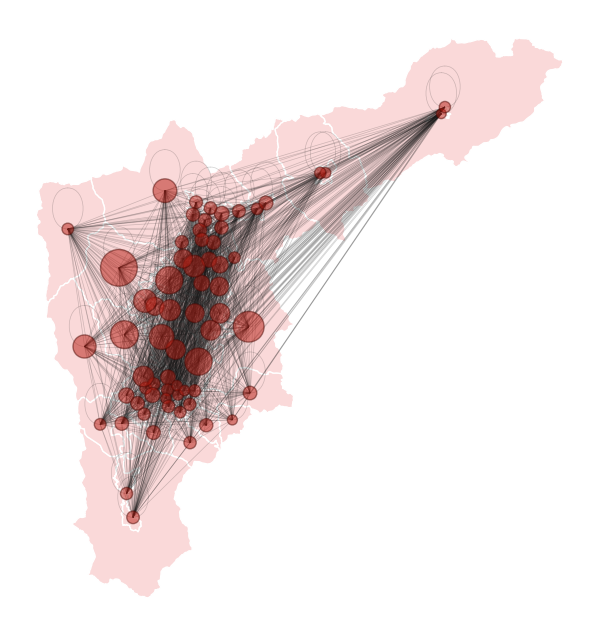

In [8]:
_ = gpd.plotting.plot_series(geoms.geometry, color='#fad9d9')
_ = nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_color='#b51b10',
                           edgecolors='#4d0904', 
                           alpha=0.5,
                           node_size=[d.get('population', 100) for n, d in G.nodes(data=True)],)
_ = nx.draw_networkx_edges(G, 
                           pos=pos,  
                           width=0.5,
                           alpha=0.2)

_ = plt.axis('off')

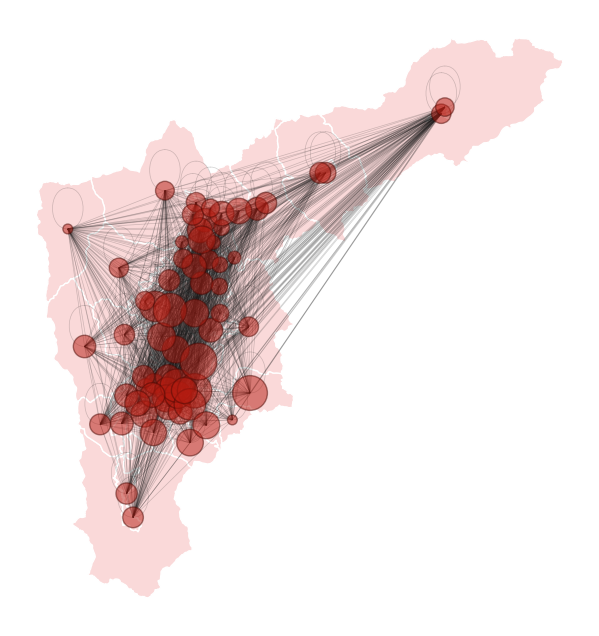

In [9]:
_ = gpd.plotting.plot_series(geoms.geometry, color='#fad9d9')
_ = nx.draw_networkx_nodes(G, 
                           pos=pos,
                           node_color='#b51b10',
                           edgecolors='#4d0904', 
                           alpha=0.5,
                           node_size=[d.get('stratum', 100) for n, d in G.nodes(data=True)],)
_ = nx.draw_networkx_edges(G, 
                           pos=pos,  
                           width=0.5,
                           alpha=0.2)

_ = plt.axis('off')

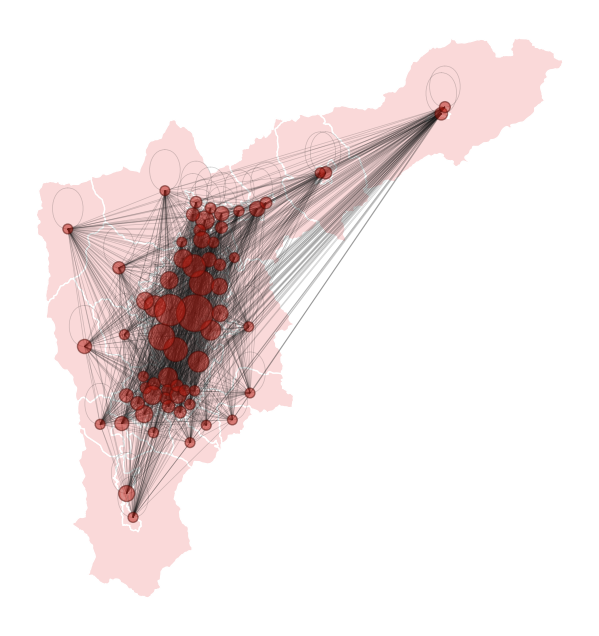

In [10]:
_ = gpd.plotting.plot_series(geoms.geometry, color='#fad9d9')
_ = nx.draw_networkx_nodes(G, 
                           pos=pos,
                           node_color='#b51b10',
                           edgecolors='#4d0904', 
                           alpha=0.5,
                           node_size=[d.get('firms', 100) for n, d in G.nodes(data=True)],)
_ = nx.draw_networkx_edges(G, 
                           pos=pos,  
                           width=0.5,
                           alpha=0.2)

_ = plt.axis('off')

## Exploring Connections By Travel Frequency and Commute Duration

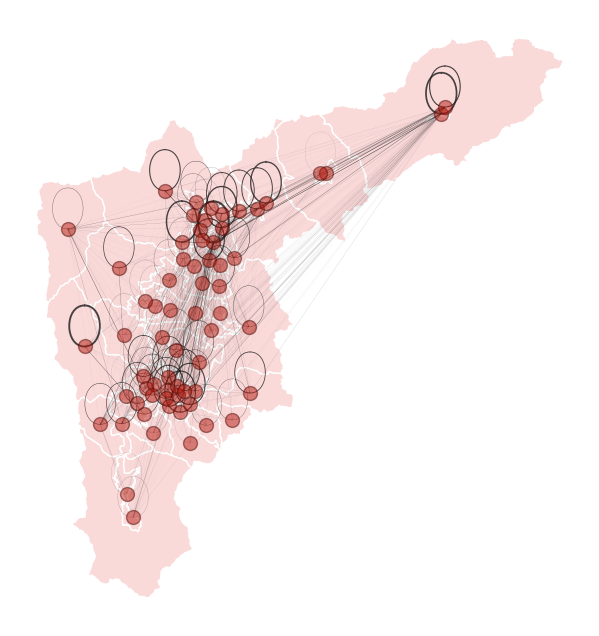

In [11]:
_ = gpd.plotting.plot_series(geoms.geometry, color='#fad9d9')
_ = nx.draw_networkx_nodes(G, 
                           pos=pos,
                           node_color='#b51b10',
                           edgecolors='#4d0904', 
                           alpha=0.5,
                           node_size=100,)
_ = nx.draw_networkx_edges(G, 
                           pos=pos, 
                           width=[d.get('str_size') * 1.5 for _, _, d in G.edges(data=True)],
                           alpha=0.8)

_ = plt.axis('off')

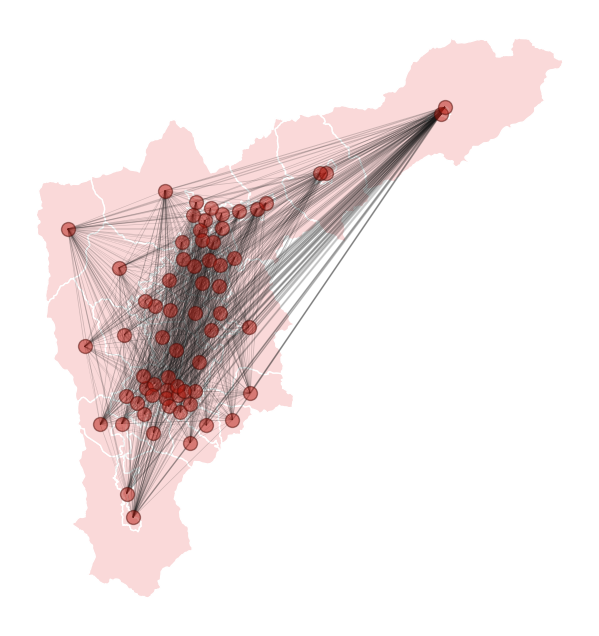

In [12]:
_ = gpd.plotting.plot_series(geoms.geometry, color='#fad9d9')
_ = nx.draw_networkx_nodes(G, 
                           pos=pos,
                           node_color='#b51b10',
                           edgecolors='#4d0904', 
                           alpha=0.5,
                           node_size=100,)
_ = nx.draw_networkx_edges(G, 
                           pos=pos, 
                           width=[d.get('tra_size', 0) for _, _, d in G.edges(data=True)],
                           alpha=0.2)

_ = plt.axis('off')

## 

## TODO:

- where is it possible to cause the biggest impact